Generating student data...
Generated 100 student records saved to 'generated_students.csv'.
Generating student data...
Generated 100 student records saved to 'generated_students.csv'.
Running NSGA-II algorithm...


Generations: 100%|██████████| 100/100 [00:00<00:00, 155.30it/s]


Best seating arrangement found: [{'UID': '202179226', 'Course': 'DL'}, {'UID': '202255117', 'Course': 'WE'}, {'UID': '202299652', 'Course': 'DB'}, {'UID': '202031234', 'Course': 'ML'}, {'UID': '202098113', 'Course': 'WE'}, {'UID': '201912158', 'Course': 'OS'}, {'UID': '201841045', 'Course': 'AI'}, {'UID': '201727319', 'Course': 'DB'}, {'UID': '202065100', 'Course': 'SE'}, {'UID': '201797138', 'Course': 'WE'}, {'UID': '201788399', 'Course': 'DL'}, {'UID': '201841045', 'Course': 'AI'}, {'UID': '202159466', 'Course': 'WE'}, {'UID': '202239793', 'Course': 'DL'}, {'UID': '202176381', 'Course': 'OS'}, {'UID': '202253768', 'Course': 'WE'}, {'UID': '201788399', 'Course': 'DL'}, {'UID': '202164254', 'Course': 'ML'}, {'UID': '202253768', 'Course': 'WE'}, {'UID': '202091762', 'Course': 'DB'}, {'UID': '201790218', 'Course': 'SE'}, {'UID': '201764795', 'Course': 'AI'}, {'UID': '202112673', 'Course': 'WE'}, {'UID': '202238090', 'Course': 'OS'}, {'UID': '202159466', 'Course': 'WE'}, {'UID': '20225376

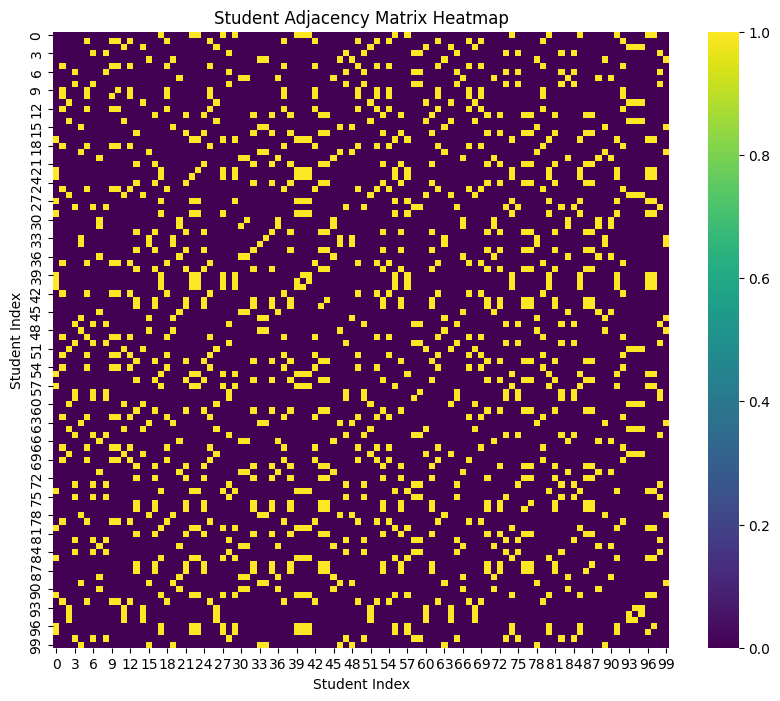

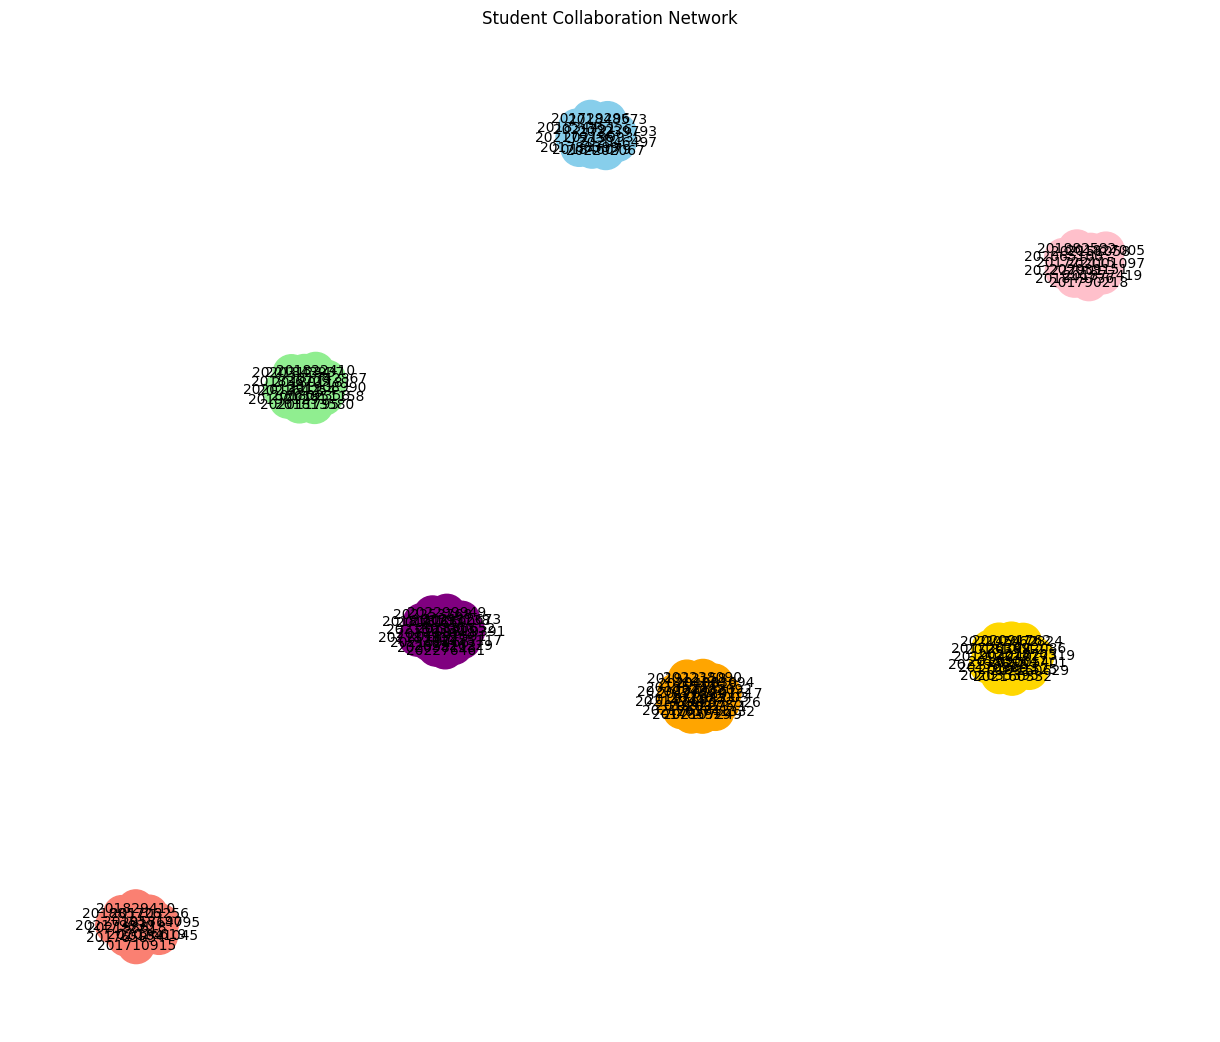

Final student arrangement after stepping through the environment: [{'UID': '201972086', 'Course': 'DB'}, {'UID': '201916590', 'Course': 'WE'}, {'UID': '202179736', 'Course': 'DL'}, {'UID': '202013311', 'Course': 'ML'}, {'UID': '201882582', 'Course': 'SE'}, {'UID': '201880652', 'Course': 'WE'}, {'UID': '201813580', 'Course': 'ML'}, {'UID': '201885726', 'Course': 'AI'}, {'UID': '201843937', 'Course': 'ML'}, {'UID': '201797138', 'Course': 'WE'}, {'UID': '202226229', 'Course': 'WE'}, {'UID': '202202067', 'Course': 'DL'}, {'UID': '201819391', 'Course': 'WE'}, {'UID': '202238090', 'Course': 'OS'}, {'UID': '202199935', 'Course': 'DL'}, {'UID': '201849736', 'Course': 'SE'}, {'UID': '201855275', 'Course': 'OS'}, {'UID': '201812012', 'Course': 'DB'}, {'UID': '202160330', 'Course': 'WE'}, {'UID': '202151058', 'Course': 'SE'}, {'UID': '201829410', 'Course': 'AI'}, {'UID': '202037371', 'Course': 'OS'}, {'UID': '202160332', 'Course': 'DB'}, {'UID': '202035395', 'Course': 'DB'}, {'UID': '201992275', 

In [53]:
# ------------------------------- IMPORTS -------------------------------
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import networkx as nx
from faker import Faker
from tqdm import tqdm  # Progress bars for iterations
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# ------------------------ GLOBAL VARIABLES -----------------------------
# Initialize Faker for generating synthetic data
fake = Faker()

# Define parameters
NUM_STUDENTS = 100  # Number of students to generate
COURSES = ['DL', 'ML', 'AI', 'DB', 'WE', 'OS', 'SE']  # Example courses
NUM_GENERATIONS = 100
POPULATION_SIZE = 100
MUTATION_RATE = 0.1
LEARNING_RATE = 0.01
BATCH_SIZE = 10  # For GAT training

# --------------------------- DATA GENERATION ----------------------------
def generate_student_data(num_students):
    """
    Generate synthetic student data with unique UIDs and assigned courses.
    """
    print("Generating student data...")
    student_data = {
        'UID': [str(random.randint(201700000, 202300000)) for _ in range(num_students)],
        'Course': [random.choice(COURSES) for _ in range(num_students)]
    }
    df = pd.DataFrame(student_data)
    df.to_csv('generated_students.csv', index=False)
    print(f"Generated {num_students} student records saved to 'generated_students.csv'.")
    return df

# Load and prepare data
df = generate_student_data(NUM_STUDENTS)
students = df.to_dict(orient='records')

# -------------------------- GRAPH CREATION ------------------------------
def create_student_graph(students):
    """
    Create a graph representation of students where nodes represent students 
    and edges indicate shared courses.
    """
    G = nx.Graph()
    for student in students:
        G.add_node(student['UID'], course=student['Course'])
    
    # Add edges between students enrolled in the same course
    for i, s1 in enumerate(students):
        for j, s2 in enumerate(students[i + 1:], i + 1):
            if s1['Course'] == s2['Course']:
                G.add_edge(s1['UID'], s2['UID'])
    return G

graph = create_student_graph(students)

# ------------------- GRAPH ATTENTION NETWORK (GAT) -----------------------
class GraphAttentionLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.a = nn.Parameter(torch.FloatTensor(2 * out_features, 1))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        nn.init.xavier_uniform_(self.a)

    def forward(self, adjacency_matrix, features):
        h = torch.matmul(features, self.weight)
        N = h.size(0)
        attention_scores = torch.zeros(N, N).to(features.device)

        # Compute attention scores between all nodes with an edge
        for i in range(N):
            for j in range(N):
                if adjacency_matrix[i, j] > 0:
                    attention_scores[i, j] = F.leaky_relu(torch.matmul(torch.cat([h[i], h[j]]), self.a))

        attention_weights = F.softmax(attention_scores, dim=1)
        return torch.matmul(attention_weights, h)

class GAT(nn.Module):
    def __init__(self, num_features, hidden_size, num_classes):
        super().__init__()
        self.gat1 = GraphAttentionLayer(num_features, hidden_size)
        self.gat2 = GraphAttentionLayer(hidden_size, num_classes)

    def forward(self, adjacency_matrix, features):
        x = F.relu(self.gat1(adjacency_matrix, features))
        return self.gat2(adjacency_matrix, x)

# ------------------------ MULTI-OBJECTIVE FITNESS ------------------------
def multi_objective_fitness(arrangement):
    """
    Compute proximity penalty, collaboration score, and diversity score
    for a given seating arrangement.
    """
    proximity_penalty = 0
    collaboration_score = 0
    courses_set = set()

    for i, student in enumerate(arrangement):
        course = student['Course']
        courses_set.add(course)
        if i > 0 and arrangement[i - 1]['Course'] == course:
            proximity_penalty += 1
        collaboration_score += np.random.random()  # Placeholder for collaboration score

    diversity_score = len(courses_set)  # Number of unique courses
    return (proximity_penalty, -collaboration_score, -diversity_score)

# ------------------------ NSGA-II ALGORITHM ------------------------------
def crossover(parent1, parent2):
    return random.sample(parent1 + parent2, len(parent1))

def mutate(child, mutation_rate=MUTATION_RATE):
    for i in range(len(child)):
        if random.random() < mutation_rate:
            child[i] = random.choice([s for s in child if s != child[i]])

def nsga_ii_algorithm(students, num_generations=NUM_GENERATIONS, population_size=POPULATION_SIZE):
    """
    Run NSGA-II for multi-objective optimization.
    """
    population = [random.sample(students, len(students)) for _ in range(population_size)]
    
    print("Running NSGA-II algorithm...")
    for _ in tqdm(range(num_generations), desc="Generations"):
        fitness_values = [multi_objective_fitness(ind) for ind in population]
        sorted_indices = np.lexsort(np.array(fitness_values).T[::-1])
        new_population = [population[i] for i in sorted_indices[:population_size // 2]]

        while len(new_population) < population_size:
            p1, p2 = random.sample(new_population[:30], 2)
            child = crossover(p1, p2)
            mutate(child, mutation_rate=MUTATION_RATE)
            new_population.append(child)

        population = new_population

    return population[0]

# ------------------ SEATING ARRANGEMENT ENVIRONMENT ---------------------
class StudentAgent:
    def __init__(self, uid, course):
        self.uid = uid
        self.course = course
        self.position = None
        self.reward = 0

    def update_position(self, new_position):
        self.position = new_position

    def calculate_reward(self, arrangement):
        # Define a reward structure based on position
        # (E.g., reward based on proximity to preferred course mates)
        return random.random()  # Placeholder for reward calculation

class SeatingEnvironment:
    def __init__(self, students):
        self.students = [StudentAgent(s['UID'], s['Course']) for s in students]

    def reset(self):
        for student in self.students:
            student.position = None
            student.reward = 0

    def step(self):
        for student in self.students:
            student.update_position(random.randint(0, len(self.students) - 1))
            student.reward += student.calculate_reward(self.students)

    def get_arrangement(self):
        return [{'UID': s.uid, 'Course': s.course} for s in self.students]

# ---------------------- ADDITIONAL VISUALIZATIONS ------------------------

def plot_adjacency_heatmap(adj_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(adj_matrix, cmap='viridis', square=True, cbar=True)
    plt.title('Student Adjacency Matrix Heatmap')
    plt.xlabel('Student Index')
    plt.ylabel('Student Index')
    plt.show()

def plot_course_network(G):
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12, 10))

    # Define a color mapping for each course
    course_colors = {
        'DL': 'skyblue',
        'ML': 'lightgreen',
        'AI': 'salmon',
        'DB': 'gold',
        'WE': 'purple',
        'OS': 'orange',
        'SE': 'pink'
    }

    # Map each node to its course color
    color_map = [course_colors[G.nodes[node]['course']] for node in G.nodes]

    # Draw the graph
    nx.draw(G, pos, node_color=color_map, with_labels=True, node_size=700, font_size=10, font_color='black')
    plt.title('Student Collaboration Network')
    plt.show()

# Main Execution
if __name__ == '__main__':
    # Generate data and create graph
    df = generate_student_data(NUM_STUDENTS)
    graph = create_student_graph(df.to_dict(orient='records'))

    # Run the NSGA-II algorithm
    best_arrangement = nsga_ii_algorithm(df.to_dict(orient='records'))
    print("Best seating arrangement found:", best_arrangement)

    # Visualize the adjacency matrix heatmap
    adjacency_matrix = nx.to_numpy_array(graph)
    plot_adjacency_heatmap(adjacency_matrix)

    # Visualize the course network
    plot_course_network(graph)

    # Initialize the seating environment
    seating_env = SeatingEnvironment(df.to_dict(orient='records'))
    seating_env.reset()

    # Step through the environment
    for _ in range(10):  # Example steps
        seating_env.step()

    # Display final arrangement
    final_arrangement = seating_env.get_arrangement()
    print("Final student arrangement after stepping through the environment:", final_arrangement)


Generating student data...
Generated 100 student records saved to 'generated_students.csv'.
Epoch [10/100], Loss: 1.9341
Epoch [20/100], Loss: 1.9102
Epoch [30/100], Loss: 1.8200
Epoch [40/100], Loss: 1.6329
Epoch [50/100], Loss: 1.4588
Epoch [60/100], Loss: 1.2993
Epoch [70/100], Loss: 1.1687
Epoch [80/100], Loss: 1.0824
Epoch [90/100], Loss: 1.0204
Epoch [100/100], Loss: 0.9557
Running NSGA-II algorithm...


Generations: 100%|██████████| 100/100 [00:00<00:00, 178.62it/s]


Best seating arrangement found: [{'UID': '202077002', 'Course': 'SE', 'Room': 'Room 4'}, {'UID': '201928274', 'Course': 'DB', 'Room': 'Room 1'}, {'UID': '202123037', 'Course': 'WE', 'Room': 'Room 3'}, {'UID': '201900692', 'Course': 'ML', 'Room': 'Room 2'}, {'UID': '201797407', 'Course': 'SE', 'Room': 'Room 2'}, {'UID': '202239423', 'Course': 'ML', 'Room': 'Room 5'}, {'UID': '202123037', 'Course': 'WE', 'Room': 'Room 3'}, {'UID': '202298250', 'Course': 'WE', 'Room': 'Room 3'}, {'UID': '201900692', 'Course': 'ML', 'Room': 'Room 2'}, {'UID': '202000310', 'Course': 'DL', 'Room': 'Room 4'}, {'UID': '202040237', 'Course': 'SE', 'Room': 'Room 1'}, {'UID': '201921122', 'Course': 'OS', 'Room': 'Room 2'}, {'UID': '201966971', 'Course': 'WE', 'Room': 'Room 1'}, {'UID': '202129121', 'Course': 'DL', 'Room': 'Room 5'}, {'UID': '201869753', 'Course': 'SE', 'Room': 'Room 1'}, {'UID': '201850832', 'Course': 'AI', 'Room': 'Room 4'}, {'UID': '201891947', 'Course': 'DL', 'Room': 'Room 1'}, {'UID': '202014

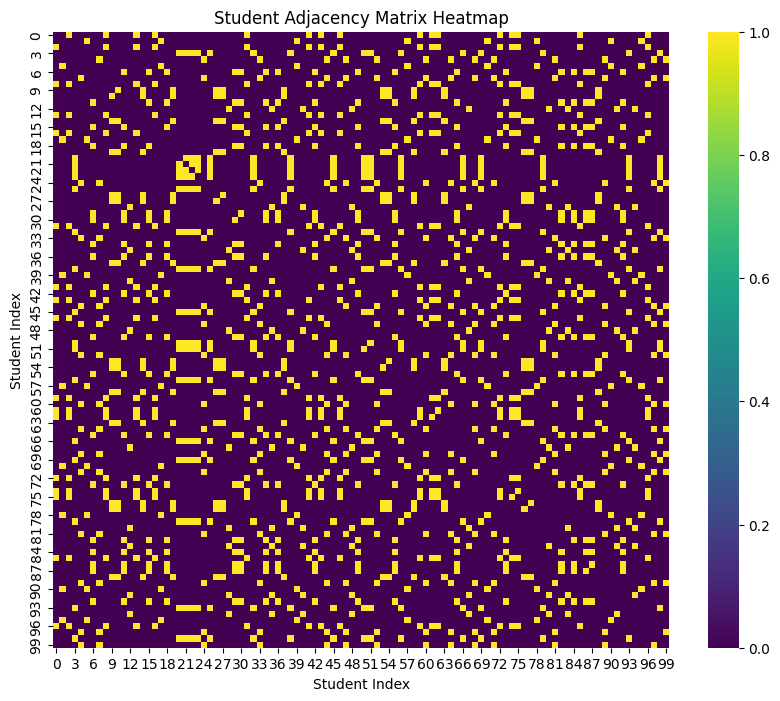

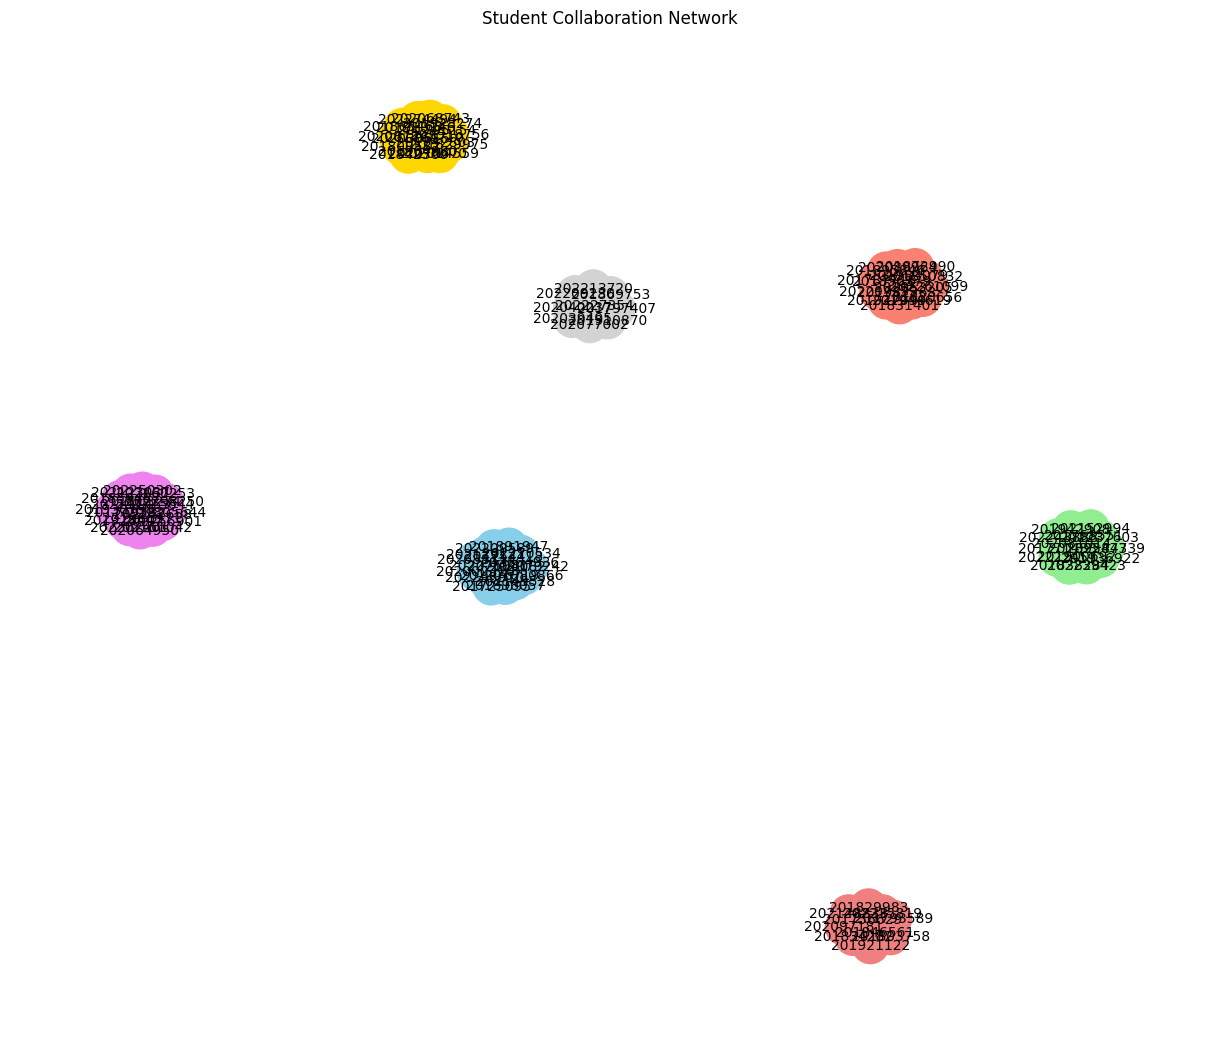

Final student arrangement after stepping through the environment: [{'UID': '201891947', 'Course': 'DL', 'Room': 'Room 1'}, {'UID': '202213720', 'Course': 'SE', 'Room': 'Room 1'}, {'UID': '201880866', 'Course': 'DL', 'Room': 'Room 1'}, {'UID': '201928274', 'Course': 'DB', 'Room': 'Room 1'}, {'UID': '201787718', 'Course': 'AI', 'Room': 'Room 1'}, {'UID': '202040237', 'Course': 'SE', 'Room': 'Room 1'}, {'UID': '201928447', 'Course': 'WE', 'Room': 'Room 1'}, {'UID': '202053205', 'Course': 'AI', 'Room': 'Room 1'}, {'UID': '202088114', 'Course': 'DL', 'Room': 'Room 1'}, {'UID': '202284739', 'Course': 'ML', 'Room': 'Room 1'}, {'UID': '201768551', 'Course': 'ML', 'Room': 'Room 1'}, {'UID': '201966971', 'Course': 'WE', 'Room': 'Room 1'}, {'UID': '201756629', 'Course': 'OS', 'Room': 'Room 1'}, {'UID': '202104082', 'Course': 'DL', 'Room': 'Room 1'}, {'UID': '201838284', 'Course': 'ML', 'Room': 'Room 1'}, {'UID': '202191453', 'Course': 'WE', 'Room': 'Room 1'}, {'UID': '202176719', 'Course': 'DL', 

In [65]:
# ------------------------------- IMPORTS -------------------------------
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import networkx as nx
from faker import Faker
from tqdm import tqdm  # Progress bars for iterations
import seaborn as sns

# ------------------------ GLOBAL VARIABLES -----------------------------
# Initialize Faker for generating synthetic data
fake = Faker()

# Define parameters
NUM_STUDENTS = 100  # Number of students to generate
NUM_ROOMS = 5       # Number of rooms available
ROOM_CAPACITY = 20  # Capacity of each room
COURSES = ['DL', 'ML', 'AI', 'DB', 'WE', 'OS', 'SE']  # Example courses
NUM_GENERATIONS = 100
POPULATION_SIZE = 100
MUTATION_RATE = 0.1
LEARNING_RATE = 0.01
BATCH_SIZE = 10  # For GAT training

# --------------------------- DATA GENERATION ----------------------------
def generate_student_data(num_students):
    """
    Generate synthetic student data with unique UIDs and assigned courses.
    """
    print("Generating student data...")
    student_data = {
        'UID': [str(random.randint(201700000, 202300000)) for _ in range(num_students)],
        'Course': [random.choice(COURSES) for _ in range(num_students)]
    }
    df = pd.DataFrame(student_data)
    df.to_csv('generated_students.csv', index=False)
    print(f"Generated {num_students} student records saved to 'generated_students.csv'.")
    return df

# ------------------- ROOM ALLOCATION ------------------------------
def allocate_students_to_rooms(students, num_rooms, room_capacity):
    """
    Allocate students to rooms based on room capacity.
    Returns a dictionary with room assignments.
    """
    room_assignments = {f'Room {i+1}': [] for i in range(num_rooms)}
    for student in students:
        # Find a room with available capacity
        assigned = False
        for room, occupants in room_assignments.items():
            if len(occupants) < room_capacity:
                occupants.append(student)
                assigned = True
                student['Room'] = room  # Assign room to student
                break
        if not assigned:
            print(f"Warning: {student['UID']} could not be assigned to a room due to capacity issues.")
    
    return room_assignments

# -------------------------- GRAPH CREATION ------------------------------
def create_student_graph(students):
    """
    Create a graph representation of students where nodes represent students 
    and edges indicate shared courses.
    """
    G = nx.Graph()
    for student in students:
        G.add_node(student['UID'], course=student['Course'], room=student.get('Room'))  # Use get() to avoid KeyError
    
    # Add edges between students enrolled in the same course
    for i, s1 in enumerate(students):
        for j, s2 in enumerate(students[i + 1:], i + 1):
            if s1['Course'] == s2['Course']:
                G.add_edge(s1['UID'], s2['UID'])
    return G

# ------------------- GRAPH ATTENTION NETWORK (GAT) -----------------------
class GraphAttentionLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.a = nn.Parameter(torch.FloatTensor(2 * out_features, 1))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        nn.init.xavier_uniform_(self.a)

    def forward(self, adjacency_matrix, features):
        h = torch.matmul(features, self.weight)
        N = h.size(0)
        attention_scores = torch.zeros(N, N).to(features.device)

        # Compute attention scores between all nodes with an edge
        for i in range(N):
            for j in range(N):
                if adjacency_matrix[i, j] > 0:
                    attention_scores[i, j] = F.leaky_relu(torch.matmul(torch.cat([h[i], h[j]]), self.a))

        attention_weights = F.softmax(attention_scores, dim=1)
        return torch.matmul(attention_weights, h)

class GAT(nn.Module):
    def __init__(self, num_features, hidden_size, num_classes):
        super().__init__()
        self.gat1 = GraphAttentionLayer(num_features, hidden_size)
        self.gat2 = GraphAttentionLayer(hidden_size, num_classes)

    def forward(self, adjacency_matrix, features):
        x = F.relu(self.gat1(adjacency_matrix, features))
        return self.gat2(adjacency_matrix, x)
    
# -------------------------- GAT TRAINING FUNCTION -----------------------
def train_gat_model(graph, features, num_epochs=100, learning_rate=LEARNING_RATE):
    """
    Train the Graph Attention Network (GAT) model on the given graph data.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Convert adjacency matrix and features to PyTorch tensors
    adjacency_matrix = torch.FloatTensor(nx.to_numpy_array(graph)).to(device)
    features = torch.FloatTensor(features).to(device)

    # Define the GAT model, loss function, and optimizer
    num_features = features.shape[1]  # Number of input features
    num_classes = len(set(student['Course'] for student in students))  # Correct way to get unique courses
    model = GAT(num_features=num_features, hidden_size=8, num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        output = model(adjacency_matrix, features)
        labels = torch.LongTensor([COURSES.index(s['Course']) for s in students]).to(device)  # Use students to get labels
        loss = criterion(output, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    return model



# ------------------------ MULTI-OBJECTIVE FITNESS ------------------------
def multi_objective_fitness(arrangement):
    """
    Compute proximity penalty, collaboration score, and diversity score
    for a given seating arrangement.
    """
    proximity_penalty = 0
    collaboration_score = 0
    courses_set = set()
    
    # Create a mapping of student UIDs to their courses for quick lookup
    uid_to_course = {student['UID']: student['Course'] for student in arrangement}

    for i, student in enumerate(arrangement):
        course = student['Course']
        courses_set.add(course)
        
        # Calculate proximity penalty (penalize for adjacent students in the same course)
        if i > 0 and uid_to_course[arrangement[i - 1]['UID']] == course:
            proximity_penalty += 1

        # Collaboration score (simple example: score increases with more adjacent students in the same course)
        if i > 0 and uid_to_course[arrangement[i - 1]['UID']] == course:
            collaboration_score += 1  # Increase score for collaboration

    diversity_score = len(courses_set)  # Number of unique courses
    return (proximity_penalty, -collaboration_score, -diversity_score)


# ------------------------ NSGA-II ALGORITHM ------------------------------
def crossover(parent1, parent2):
    return random.sample(parent1 + parent2, len(parent1))

def mutate(child, mutation_rate=MUTATION_RATE):
    for i in range(len(child)):
        if random.random() < mutation_rate:
            child[i] = random.choice([s for s in child if s != child[i]])

def nsga_ii_algorithm(students, num_generations=NUM_GENERATIONS, population_size=POPULATION_SIZE):
    """
    Run NSGA-II for multi-objective optimization.
    """
    population = [random.sample(students, len(students)) for _ in range(population_size)]
    
    print("Running NSGA-II algorithm...")
    for _ in tqdm(range(num_generations), desc="Generations"):
        fitness_values = [multi_objective_fitness(ind) for ind in population]
        sorted_indices = np.lexsort(np.array(fitness_values).T[::-1])
        new_population = [population[i] for i in sorted_indices[:population_size // 2]]

        while len(new_population) < population_size:
            p1, p2 = random.sample(new_population[:30], 2)
            child = crossover(p1, p2)
            mutate(child, mutation_rate=MUTATION_RATE)
            new_population.append(child)

        population = new_population

    return population[0]

# ------------------ SEATING ARRANGEMENT ENVIRONMENT ---------------------
class StudentAgent:
    def __init__(self, uid, course, room=None):
        self.uid = uid
        self.course = course
        self.room = room  # Added room attribute
        self.position = None
        self.reward = 0

    def update_position(self, new_position):
        self.position = new_position

    def calculate_reward(self, arrangement):
        # Reward structure based on proximity to preferred course mates
        reward = 0
        for idx, student in enumerate(arrangement):
            if student.uid == self.uid:  # Corrected access to uid
                # Check adjacent positions
                if idx > 0 and arrangement[idx - 1].course == self.course:  # Corrected access to course
                    reward += 1  # Reward for being next to a course mate
                if idx < len(arrangement) - 1 and arrangement[idx + 1].course == self.course:  # Corrected access to course
                    reward += 1  # Reward for being next to a course mate
                break  # Exit loop once we find the current student's position
        return reward  # Return the calculated reward

class SeatingEnvironment:
    def __init__(self, students):
        self.students = [StudentAgent(s['UID'], s['Course'], s.get('Room')) for s in students]

    def reset(self):
        for student in self.students:
            student.position = None
            student.reward = 0

    def step(self):
        for student in self.students:
            student.update_position(random.randint(0, len(self.students) - 1))
            student.reward += student.calculate_reward(self.students)

    def get_arrangement(self):
        return [{'UID': s.uid, 'Course': s.course, 'Room': s.room} for s in self.students]


# ---------------------- ADDITIONAL VISUALIZATIONS ------------------------

def plot_adjacency_heatmap(adj_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(adj_matrix, cmap='viridis', square=True, cbar=True)
    plt.title('Student Adjacency Matrix Heatmap')
    plt.xlabel('Student Index')
    plt.ylabel('Student Index')
    plt.show()

def plot_course_network(G):
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12, 10))

    # Define a color mapping for each course
    course_colors = {
        'DL': 'skyblue',
        'ML': 'lightgreen',
        'AI': 'salmon',
        'DB': 'gold',
        'WE': 'violet',
        'OS': 'lightcoral',
        'SE': 'lightgray'
    }

    # Color the nodes according to their courses
    color_map = [course_colors[G.nodes[node]['course']] for node in G.nodes]

    # Draw the graph
    nx.draw(G, pos, node_color=color_map, with_labels=True, node_size=700, font_size=10, font_color='black')
    plt.title('Student Collaboration Network')
    plt.show()

# --------------------- MAIN EXECUTION ---------------------
if __name__ == '__main__':
    # Generate data and create students
    df = generate_student_data(NUM_STUDENTS)
    students = df.to_dict(orient='records')  # Refresh the student data

    # Allocate students to rooms before creating the graph
    room_assignments = allocate_students_to_rooms(students, NUM_ROOMS, ROOM_CAPACITY)
    
    # Create the graph after room allocation
    graph = create_student_graph(students)

    # Prepare feature matrix (one-hot encoding of courses)
    features = pd.get_dummies(df['Course']).values

    # Train the GAT model
    trained_gat_model = train_gat_model(graph, features)

    # Run the NSGA-II algorithm to find the best arrangement
    best_arrangement = nsga_ii_algorithm(students)
    print("Best seating arrangement found:", best_arrangement)

    # Visualize the adjacency matrix heatmap
    adjacency_matrix = nx.to_numpy_array(graph)
    plot_adjacency_heatmap(adjacency_matrix)

    # Visualize the course network
    plot_course_network(graph)

    # Initialize the seating environment
    seating_env = SeatingEnvironment(students)
    seating_env.reset()

    # Step through the environment
    for _ in range(10):  # Example steps
        seating_env.step()

    # Display final arrangement
    final_arrangement = seating_env.get_arrangement()
    print("Final student arrangement after stepping through the environment:", final_arrangement)



Generating student data...
Generated 100 student records saved to 'generated_students.csv'.
Epoch [10/100], Loss: 1.9459
Epoch [20/100], Loss: 1.9380
Epoch [30/100], Loss: 1.9110
Epoch [40/100], Loss: 1.8420
Epoch [50/100], Loss: 1.7352
Epoch [60/100], Loss: 1.6139
Epoch [70/100], Loss: 1.5151
Epoch [80/100], Loss: 1.3948
Epoch [90/100], Loss: 1.2646
Epoch [100/100], Loss: 1.1489
Running NSGA-II algorithm...


Generations: 100%|██████████| 100/100 [00:00<00:00, 171.97it/s]


Best seating arrangement found: [{'UID': '201857844', 'Course': 'AI', 'Room': 'Room 4'}, {'UID': '202134805', 'Course': 'ML', 'Room': 'Room 5'}, {'UID': '202252564', 'Course': 'AI', 'Room': 'Room 1'}, {'UID': '201992477', 'Course': 'DB', 'Room': 'Room 2'}, {'UID': '201901677', 'Course': 'WE', 'Room': 'Room 2'}, {'UID': '201796386', 'Course': 'AI', 'Room': 'Room 2'}, {'UID': '202140964', 'Course': 'OS', 'Room': 'Room 2'}, {'UID': '201969791', 'Course': 'ML', 'Room': 'Room 5'}, {'UID': '202126644', 'Course': 'SE', 'Room': 'Room 4'}, {'UID': '201890784', 'Course': 'DL', 'Room': 'Room 3'}, {'UID': '202274274', 'Course': 'OS', 'Room': 'Room 2'}, {'UID': '202057353', 'Course': 'DB', 'Room': 'Room 2'}, {'UID': '202120033', 'Course': 'AI', 'Room': 'Room 3'}, {'UID': '202040491', 'Course': 'ML', 'Room': 'Room 2'}, {'UID': '201906880', 'Course': 'DL', 'Room': 'Room 5'}, {'UID': '202009661', 'Course': 'OS', 'Room': 'Room 1'}, {'UID': '202007288', 'Course': 'ML', 'Room': 'Room 3'}, {'UID': '202018

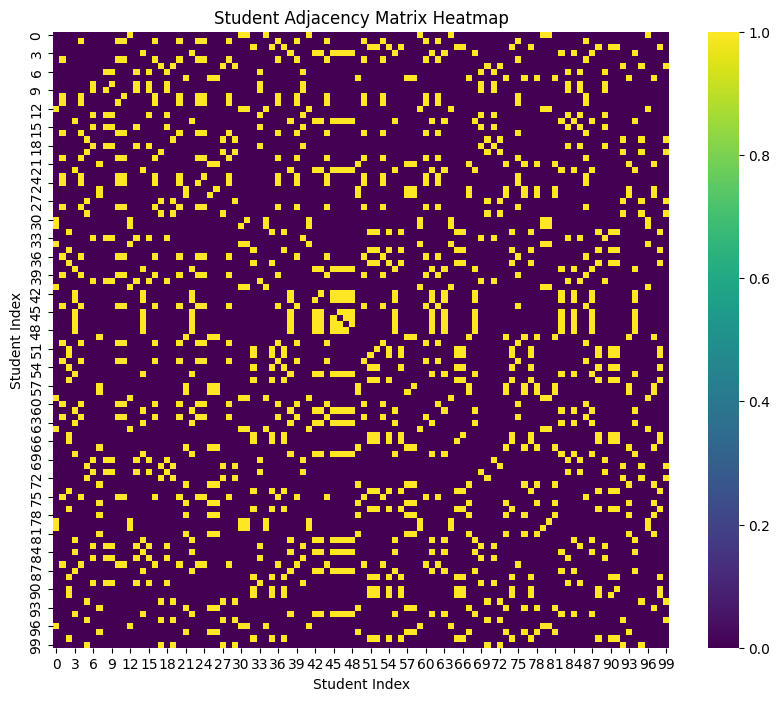

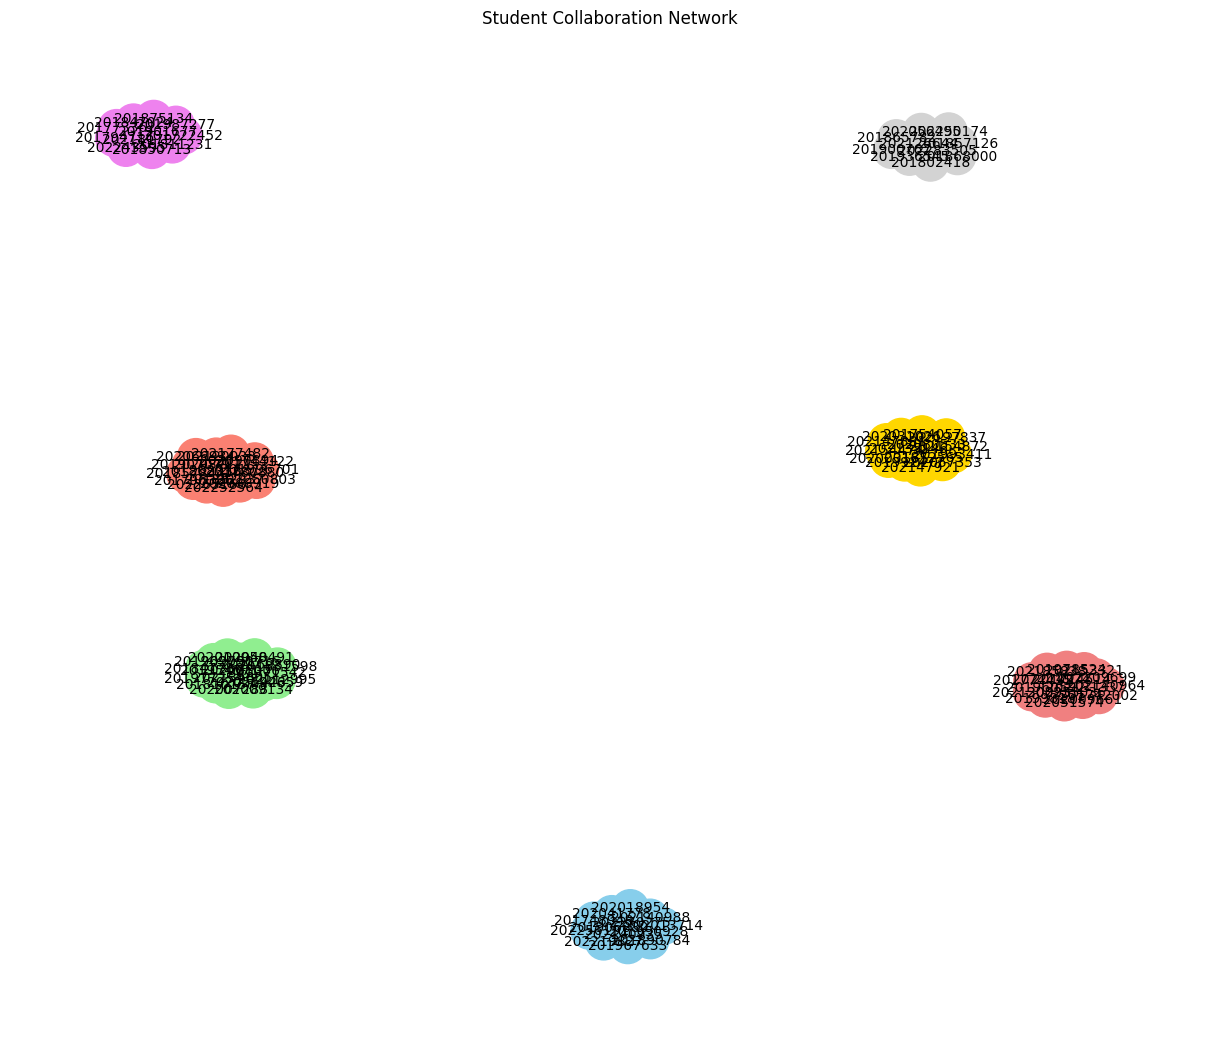

/var/folders/c2/h2wmsn3s71xcfy70pskryqk40000gn/T/ipykernel_2108/368049809.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=course_counts.index, y=course_counts.values, palette='Set2')


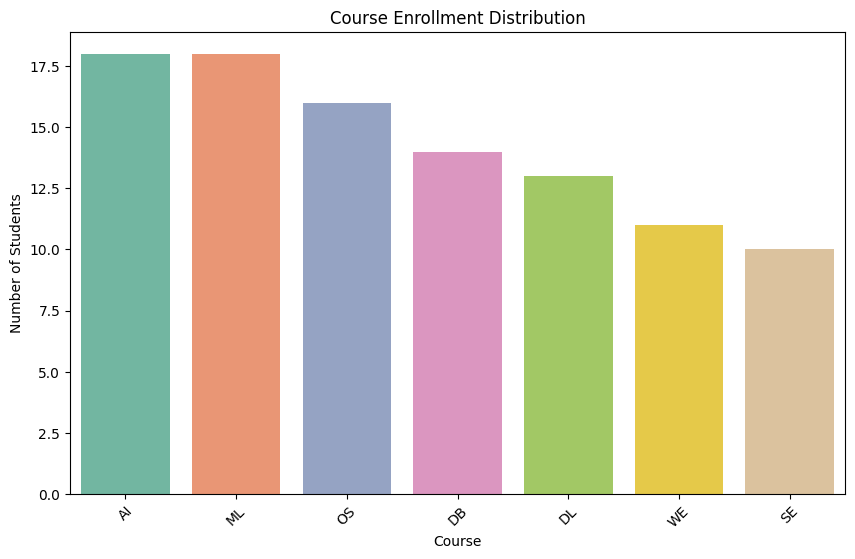

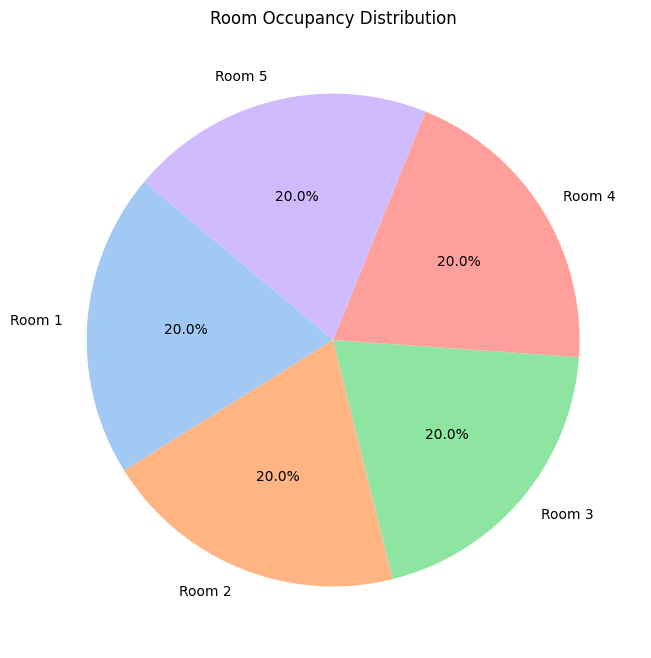

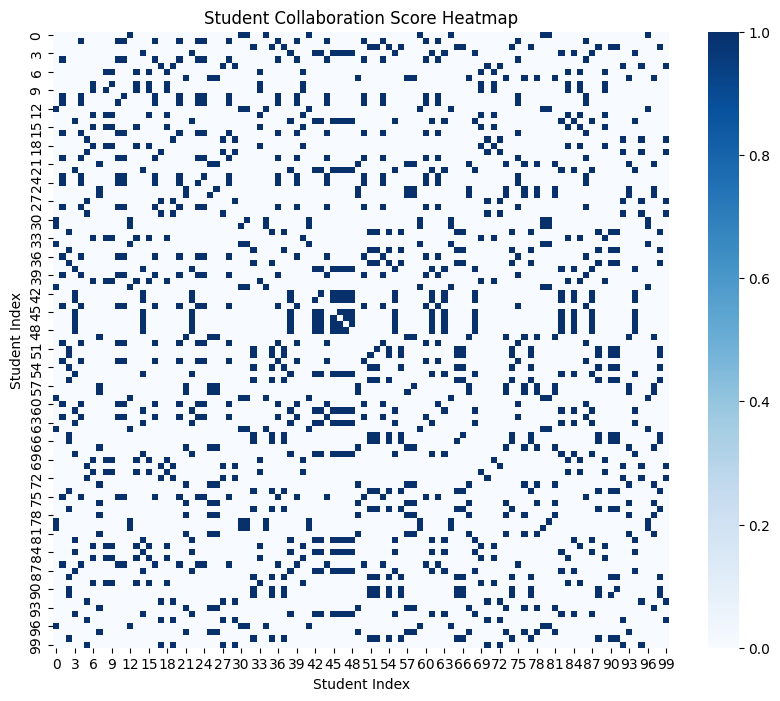


Final Seating Arrangement:
          UID Course    Room
0   201794716     WE  Room 1
1   202066934     AI  Room 1
2   202009661     OS  Room 1
3   202112995     ML  Room 1
4   201780880     AI  Room 1
..        ...    ...     ...
95  202250174     SE  Room 5
96  202243595     WE  Room 5
97  202135146     DB  Room 5
98  202153321     OS  Room 5
99  201868000     SE  Room 5

[100 rows x 3 columns]


In [68]:
def plot_course_distribution(students):
    """
    Plot a bar chart showing the distribution of students across courses.
    """
    course_counts = df['Course'].value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=course_counts.index, y=course_counts.values, palette='Set2')
    plt.title('Course Enrollment Distribution')
    plt.xlabel('Course')
    plt.ylabel('Number of Students')
    plt.xticks(rotation=45)
    plt.show()

def plot_room_occupancy(room_assignments):
    """
    Plot a pie chart showing the distribution of students across rooms.
    """
    room_counts = [len(occupants) for occupants in room_assignments.values()]
    room_labels = list(room_assignments.keys())
    
    plt.figure(figsize=(8, 8))
    plt.pie(room_counts, labels=room_labels, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
    plt.title('Room Occupancy Distribution')
    plt.show()

def plot_student_collaboration_heatmap(graph):
    """
    Plot a heatmap for collaboration scores between students based on their course sharing.
    """
    adjacency_matrix = nx.to_numpy_array(graph)
    collaboration_matrix = np.zeros(adjacency_matrix.shape)

    # Calculate collaboration scores
    for i in range(adjacency_matrix.shape[0]):
        for j in range(adjacency_matrix.shape[1]):
            if adjacency_matrix[i, j] > 0:  # There is an edge
                collaboration_matrix[i, j] = 1  # Assign a score of 1 for collaboration

    plt.figure(figsize=(10, 8))
    sns.heatmap(collaboration_matrix, cmap='Blues', square=True, cbar=True)
    plt.title('Student Collaboration Score Heatmap')
    plt.xlabel('Student Index')
    plt.ylabel('Student Index')
    plt.show()

def display_final_arrangement(final_arrangement):
    """
    Display the final seating arrangement in a tabular format.
    """
    final_df = pd.DataFrame(final_arrangement)
    print("\nFinal Seating Arrangement:")
    print(final_df)



# --------------------- MAIN EXECUTION ---------------------
if __name__ == '__main__':
    # Generate data and create students
    df = generate_student_data(NUM_STUDENTS)
    students = df.to_dict(orient='records')  # Refresh the student data

    # Allocate students to rooms before creating the graph
    room_assignments = allocate_students_to_rooms(students, NUM_ROOMS, ROOM_CAPACITY)

    # Create the graph after room allocation
    graph = create_student_graph(students)

    # Prepare feature matrix (one-hot encoding of courses)
    features = pd.get_dummies(df['Course']).values

    # Train the GAT model
    trained_gat_model = train_gat_model(graph, features)

    # Run the NSGA-II algorithm to find the best arrangement
    best_arrangement = nsga_ii_algorithm(students)
    print("Best seating arrangement found:", best_arrangement)

    # Visualize the adjacency matrix heatmap
    adjacency_matrix = nx.to_numpy_array(graph)
    plot_adjacency_heatmap(adjacency_matrix)

    # Visualize the course network
    plot_course_network(graph)

    # New Visualizations
    plot_course_distribution(students)
    plot_room_occupancy(room_assignments)
    plot_student_collaboration_heatmap(graph)

    # Initialize the seating environment
    seating_env = SeatingEnvironment(students)
    seating_env.reset()

    # Step through the environment
    for _ in range(10):  # Example steps
        seating_env.step()

    # Display final arrangement
    final_arrangement = seating_env.get_arrangement()
    display_final_arrangement(final_arrangement)
